In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from statsmodels.tsa.stattools import adfuller

In [138]:
pd.options.display.float_format = "{:,.5f}".format
np.set_printoptions(precision=3, suppress=True)
sns.set_style("whitegrid")


In [22]:
df = pd.read_csv('sales_train.csv')
test_df = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')
items = pd.read_csv('items.csv')
item_categories = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')

In [23]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.00
1,03.01.2013,0,25,2552,899.00,1.00
2,05.01.2013,0,25,2552,899.00,-1.00
3,06.01.2013,0,25,2554,"1,709.05",1.00
4,15.01.2013,0,25,2555,"1,099.00",1.00


In [7]:
data = df.groupby(['shop_id', 'item_id', 'date_block_num'], as_index=False)\
    .agg({'item_cnt_day': 'sum'}).rename({'item_cnt_day': 'item_cnt_month'}, axis=1)

In [8]:
data.head()

,shop_id,item_id,date_block_num,item_cnt_month
0,0,30,1,31.00
1,0,31,1,11.00
2,0,32,0,6.00
3,0,32,1,10.00
4,0,33,0,3.00


In [9]:
shop_5_data = data[data.shop_id == 5]

In [10]:
shop_5_data

,shop_id,item_id,date_block_num,item_cnt_month
64224,5,27,7,1.00
64225,5,27,17,1.00
64226,5,29,6,1.00
64227,5,30,1,5.00
64228,5,30,2,7.00
...,...,...,...,...
88327,5,22164,33,1.00
88328,5,22167,12,1.00
88329,5,22167,15,1.00
88330,5,22167,18,1.00


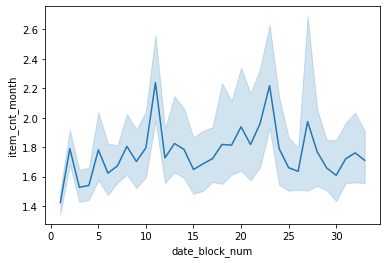

In [11]:
sns.lineplot(data=shop_5_data, x='date_block_num', y='item_cnt_month');

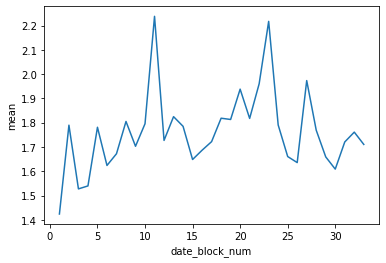

In [12]:
sns.lineplot(data=shop_5_data.groupby(['date_block_num'], as_index=False).agg({'item_cnt_month': 'mean'})\
             .rename({'item_cnt_month': 'mean'}, axis=1), x='date_block_num', y='mean');

In [119]:
def test_stationarity(timeseries, window=5):
    
    moving_average = timeseries.rolling(window).mean()
    moving_std = timeseries.rolling(window).std()
    
    print('Stationarity test results:')
    df_test = adfuller(timeseries, autolag='AIC')
    df_output = pd.Series(df_test[:4], index=['Test statistic', 'p-value', 
                                              '#Lags used', 'Number of observations used'])
    print(df_output)
    
    return df_output['p-value']

In [120]:
def differencing_timeseries(timeseries, shift=1):
    result = timeseries - timeseries.shift(shift)
    
    return result.dropna()

In [121]:
def make_stationary(timeseries, alpha=0.05):
    
    while test_stationarity(timeseries) > alpha:
        timeseries = differencing_timeseries(timeseries)

In [135]:
def test_shop_data_stationarity(data, shop_id):
    shop = data[data.shop_id == shop_id]
    
    if shop.shape[0] < 2:
        return
    
    stats=shop.groupby(['date_block_num']).agg({'item_cnt_month': ['mean', 'count', 'std']})

    ci95_hi = []
    ci95_lo = []

    for i in stats.index:
        m, c, s = stats.loc[i]
        ci95_hi.append(m + 1.95*s/math.sqrt(c))
        ci95_lo.append(m - 1.95*s/math.sqrt(c))

    stats['ci95_hi'] = ci95_hi
    stats['ci95_lo'] = ci95_lo
        
    stats.head()
    plt.figure(figsize=(10, 3))
    sns.lineplot(data=stats, x='date_block_num', y='ci95_hi', label='original');
    rolmean = stats['ci95_hi'].rolling(window=5).mean()
    rolstd = stats['ci95_hi'].rolling(window=5).std()
    sns.lineplot(data=rolmean, label='rolmean')
    sns.lineplot(data=rolstd, label='rolstd')
    plt.title('95 confidence interval high')
    plt.show()

    plt.acorr(stats['ci95_hi'], maxlags=None)
    plt.xlim([0, 34])
    plt.show()

    test_stationarity(stats['ci95_hi'])

    plt.figure(figsize=(10, 3))
    sns.lineplot(data=stats, x='date_block_num', y=stats.item_cnt_month['mean'], label='original')
    rolmean = stats['item_cnt_month']['mean'].rolling(window=5).mean()
    rolstd = stats['item_cnt_month']['mean'].rolling(window=5).std()
    sns.lineplot(data=rolmean, label='rolmean')
    sns.lineplot(data=rolstd, label='rolstd')
    plt.title('mean')
    plt.show()
    
    plt.acorr(stats['item_cnt_month']['mean'], maxlags=None)
    plt.xlim([0, 34])
    plt.show()

    test_stationarity(stats['item_cnt_month']['mean'])
    
    
    plt.figure(figsize=(10, 3))
    sns.lineplot(data=stats, x='date_block_num', y='ci95_lo', label='original');
    rolmean = stats['ci95_lo'].rolling(window=5).mean()
    rolstd = stats['ci95_lo'].rolling(window=5).std()
    sns.lineplot(data=rolmean, label='rolmean')
    sns.lineplot(data=rolstd, label='rolstd')
    plt.title('95 confidence interval low')
    plt.show()

    plt.acorr(stats['ci95_lo'], maxlags=None)
    plt.xlim([0, 34])
    plt.show()

    test_stationarity(stats['ci95_lo'])
    
    differ = differencing_timeseries(stats['ci95_lo'])
    sns.lineplot(data=differ)
    rolmean = differ.rolling(window=5).mean()
    rolstd = differ.rolling(window=5).std()
    sns.lineplot(data=rolmean, label='rolmean')
    sns.lineplot(data=rolstd, label='rolstd')
    plt.show()
    
    plt.acorr(differ, maxlags=None)
    plt.xlim([0, 34])
    plt.show()
    
    test_stationarity(differ)
    
    return stats

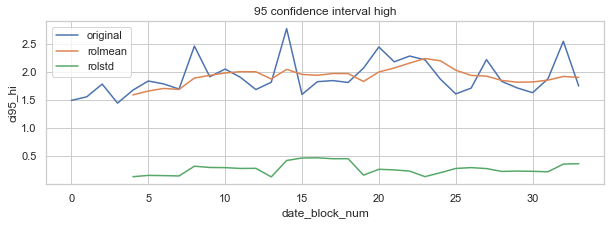

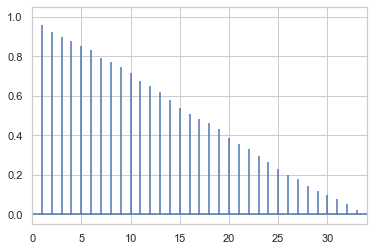

Stationarity test results:
Test statistic                -5.10078
p-value                        0.00001
#Lags used                     0.00000
Number of observations used   33.00000
dtype: float64


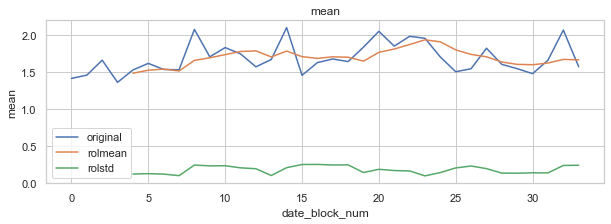

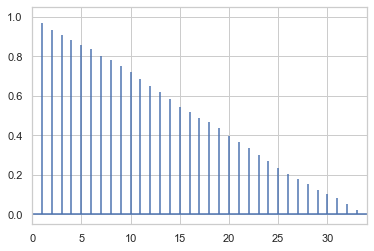

Stationarity test results:
Test statistic                -4.69099
p-value                        0.00009
#Lags used                     0.00000
Number of observations used   33.00000
dtype: float64


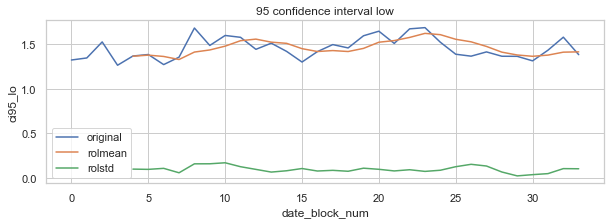

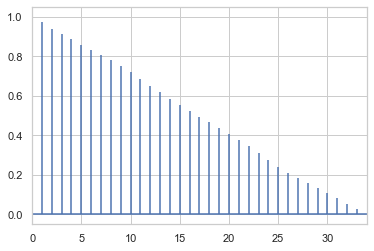

Stationarity test results:
Test statistic                -0.79122
p-value                        0.82169
#Lags used                     8.00000
Number of observations used   25.00000
dtype: float64


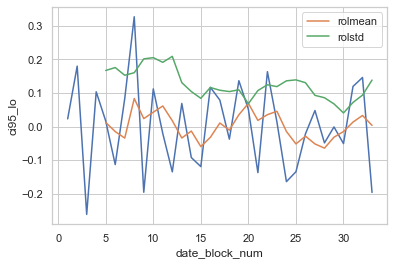

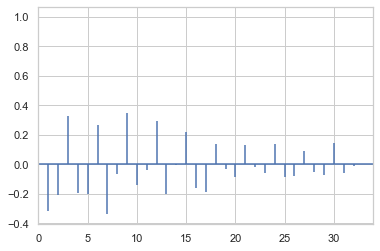

Stationarity test results:
Test statistic                -4.73192
p-value                        0.00007
#Lags used                     7.00000
Number of observations used   25.00000
dtype: float64


item_cnt_month               ci95_hi ci95_lo
                         mean count     std                
date_block_num                                             
0                     1.40993   544 1.03314 1.49630 1.32355
1                     1.45355   549 1.28585 1.56057 1.34654
2                     1.65630   579 1.60050 1.78601 1.52660
3                     1.35639   477 1.02635 1.44803 1.26476
4                     1.52361   466 1.71786 1.67878 1.36843

In [137]:
test_shop_data_stationarity(data, 3).head()

In [126]:
data.head()

,shop_id,item_id,date_block_num,item_cnt_month
0,0,30,1,31.00000
1,0,31,1,11.00000
2,0,32,0,6.00000
3,0,32,1,10.00000
4,0,33,0,3.00000


Shop_id:  2


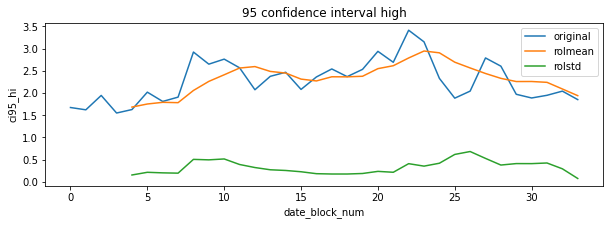

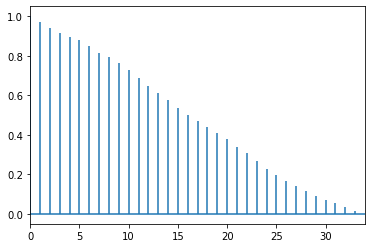

Stationarity test results:
Test statistic                -2.82970
p-value                        0.05415
#Lags used                     1.00000
Number of observations used   32.00000
dtype: float64


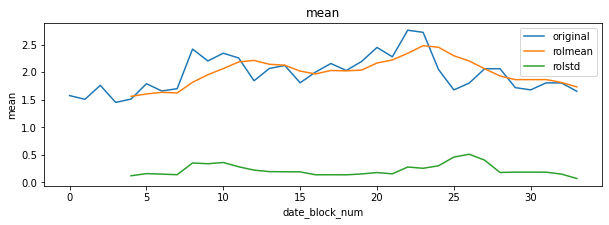

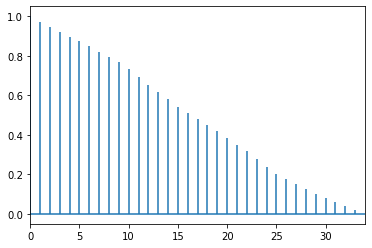

Stationarity test results:
Test statistic                -1.75722
p-value                        0.40190
#Lags used                     2.00000
Number of observations used   31.00000
dtype: float64


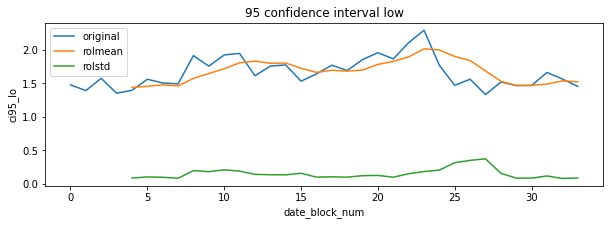

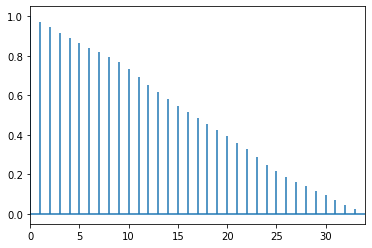

Stationarity test results:
Test statistic                -3.12683
p-value                        0.02463
#Lags used                     3.00000
Number of observations used   30.00000
dtype: float64
Shop_id:  3


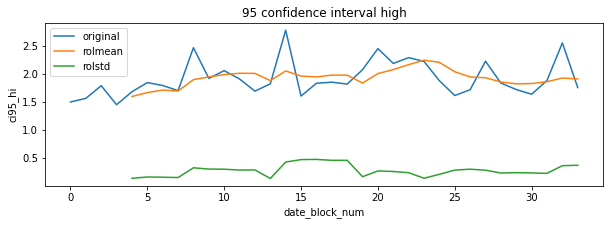

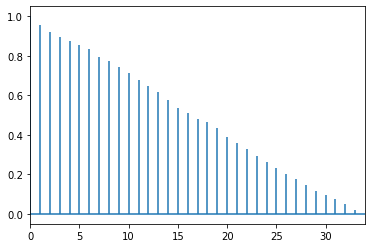

Stationarity test results:
Test statistic                -5.10078
p-value                        0.00001
#Lags used                     0.00000
Number of observations used   33.00000
dtype: float64


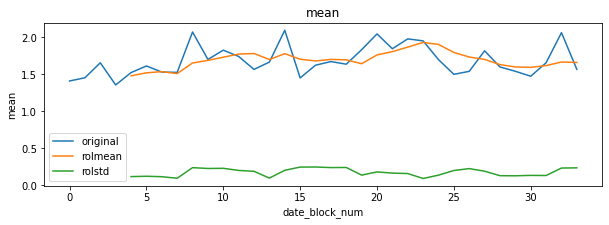

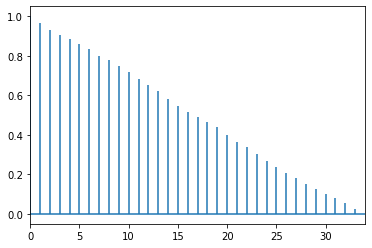

Stationarity test results:
Test statistic                -4.69099
p-value                        0.00009
#Lags used                     0.00000
Number of observations used   33.00000
dtype: float64


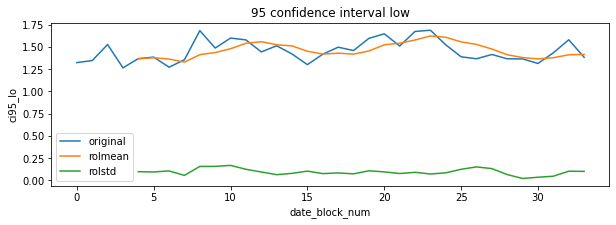

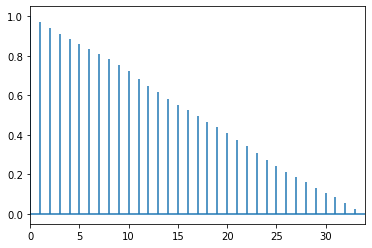

Stationarity test results:
Test statistic                -0.79122
p-value                        0.82169
#Lags used                     8.00000
Number of observations used   25.00000
dtype: float64
Shop_id:  4


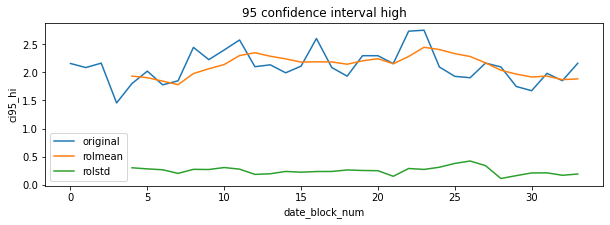

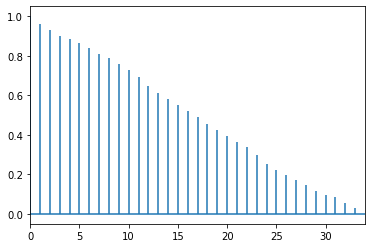

Stationarity test results:
Test statistic                -0.62757
p-value                        0.86463
#Lags used                    10.00000
Number of observations used   23.00000
dtype: float64


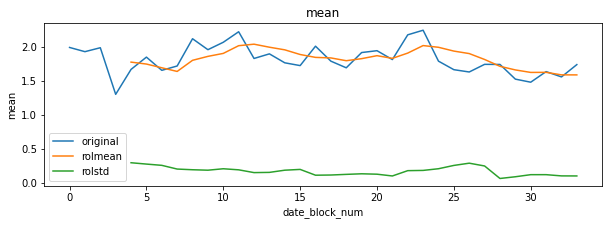

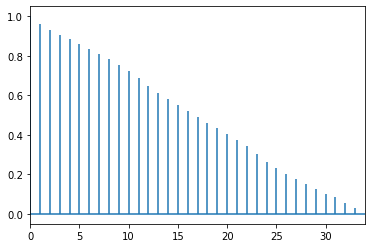

Stationarity test results:
Test statistic                 0.72700
p-value                        0.99036
#Lags used                    10.00000
Number of observations used   23.00000
dtype: float64


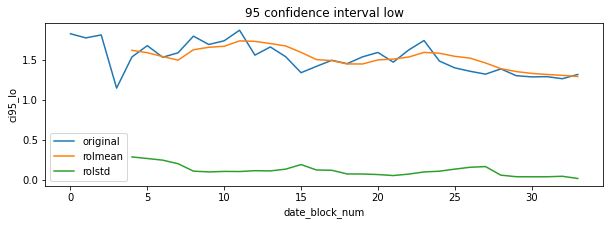

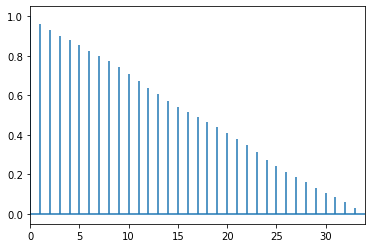

Stationarity test results:
Test statistic                 0.70775
p-value                        0.98999
#Lags used                    10.00000
Number of observations used   23.00000
dtype: float64
Shop_id:  5


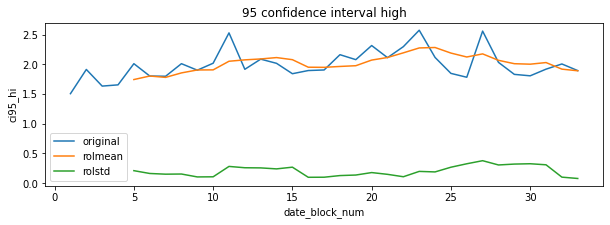

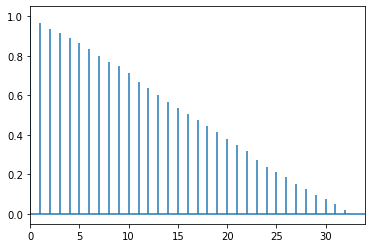

Stationarity test results:
Test statistic                -4.53022
p-value                        0.00017
#Lags used                     0.00000
Number of observations used   32.00000
dtype: float64


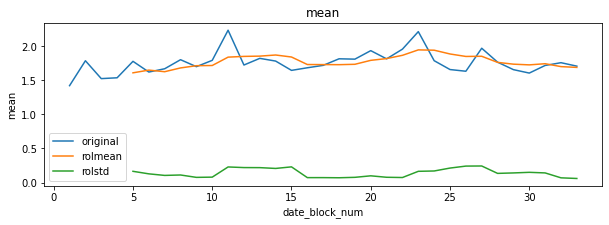

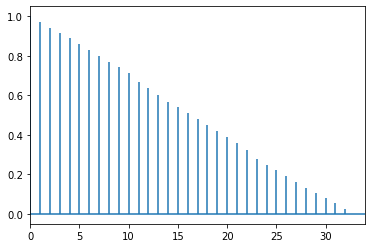

Stationarity test results:
Test statistic                -4.80225
p-value                        0.00005
#Lags used                     0.00000
Number of observations used   32.00000
dtype: float64


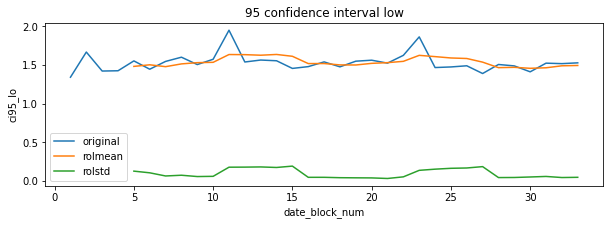

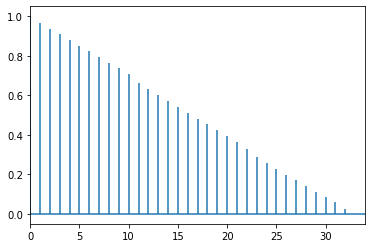

Stationarity test results:
Test statistic                -5.49705
p-value                        0.00000
#Lags used                     0.00000
Number of observations used   32.00000
dtype: float64
Shop_id:  6


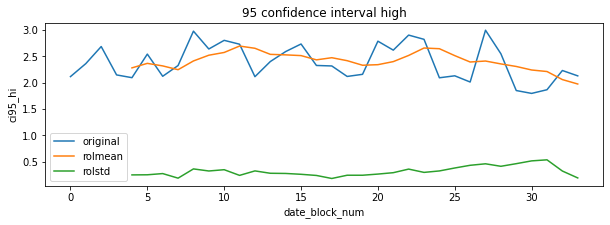

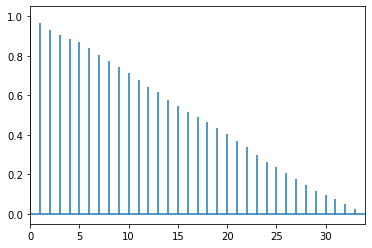

Stationarity test results:
Test statistic                -3.95570
p-value                        0.00166
#Lags used                     0.00000
Number of observations used   33.00000
dtype: float64


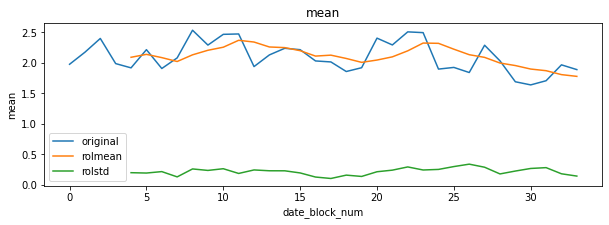

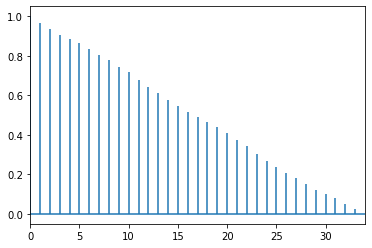

Stationarity test results:
Test statistic                -3.40517
p-value                        0.01078
#Lags used                     0.00000
Number of observations used   33.00000
dtype: float64


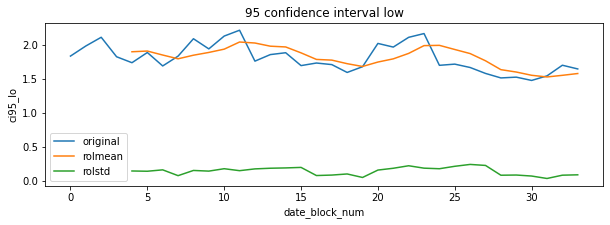

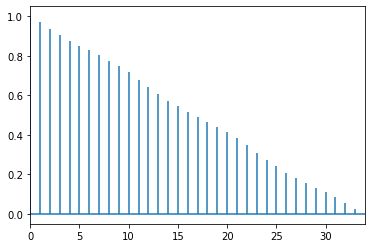

Stationarity test results:
Test statistic                 0.51189
p-value                        0.98523
#Lags used                    10.00000
Number of observations used   23.00000
dtype: float64
Shop_id:  7


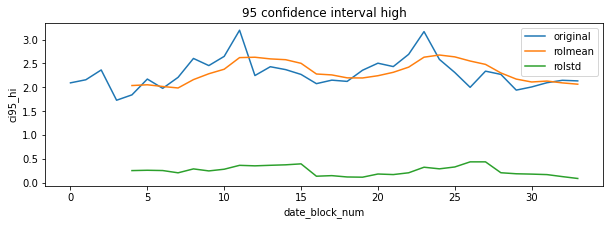

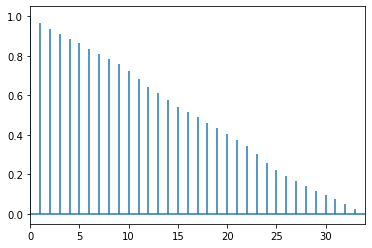

Stationarity test results:
Test statistic                -3.21973
p-value                        0.01887
#Lags used                     0.00000
Number of observations used   33.00000
dtype: float64


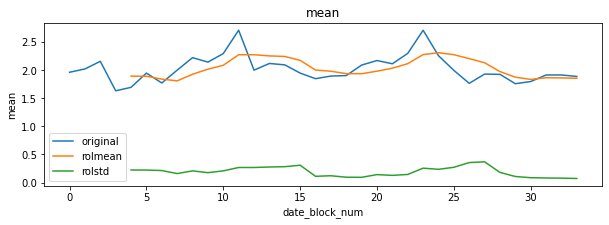

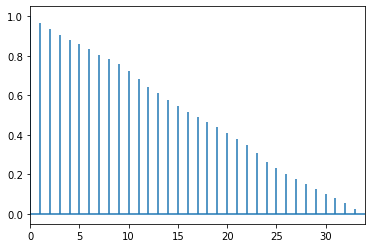

Stationarity test results:
Test statistic                -3.17812
p-value                        0.02129
#Lags used                     0.00000
Number of observations used   33.00000
dtype: float64


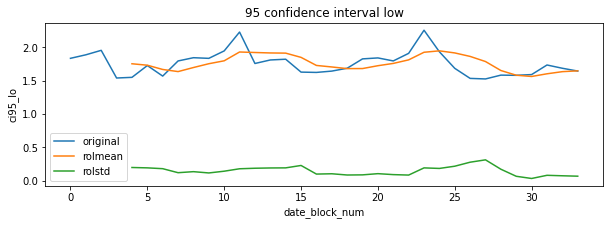

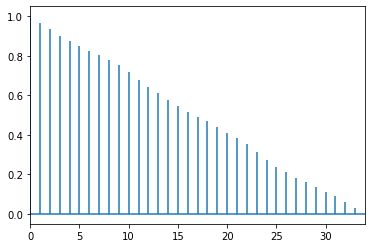

Stationarity test results:
Test statistic                -3.13619
p-value                        0.02399
#Lags used                     0.00000
Number of observations used   33.00000
dtype: float64
Shop_id:  10


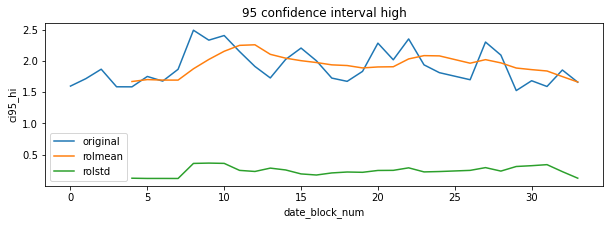

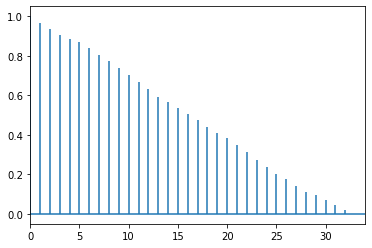

Stationarity test results:
Test statistic                -3.32138
p-value                        0.01395
#Lags used                     0.00000
Number of observations used   32.00000
dtype: float64


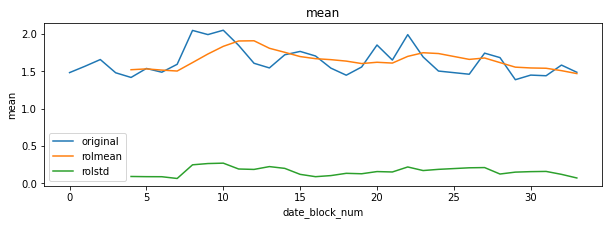

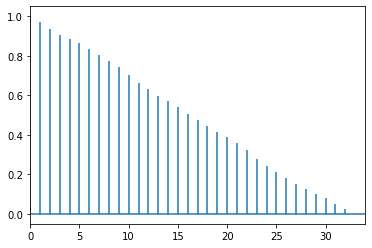

Stationarity test results:
Test statistic                -3.05914
p-value                        0.02973
#Lags used                     0.00000
Number of observations used   32.00000
dtype: float64


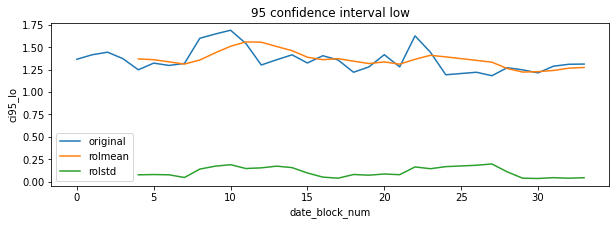

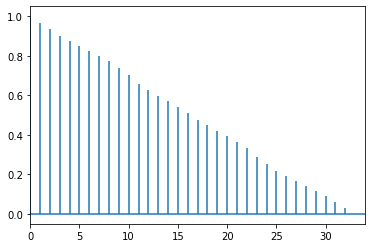

Stationarity test results:
Test statistic                -2.94307
p-value                        0.04056
#Lags used                     0.00000
Number of observations used   32.00000
dtype: float64
Shop_id:  12


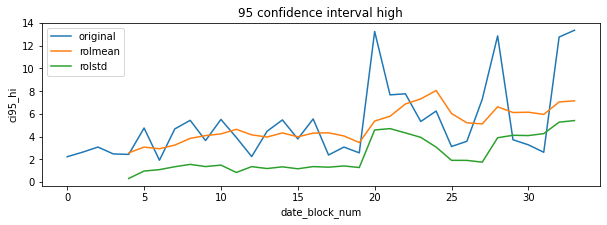

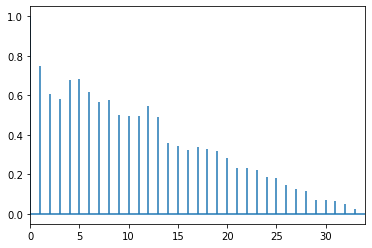

Stationarity test results:
Test statistic                -1.67638
p-value                        0.44332
#Lags used                     3.00000
Number of observations used   30.00000
dtype: float64


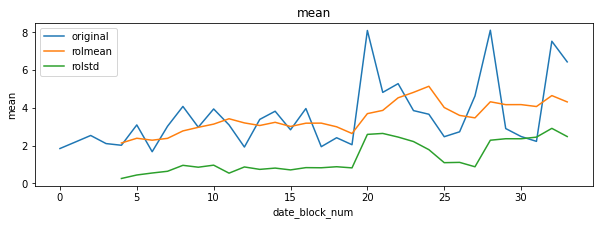

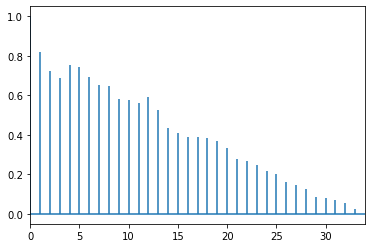

Stationarity test results:
Test statistic                -3.33243
p-value                        0.01349
#Lags used                     2.00000
Number of observations used   31.00000
dtype: float64


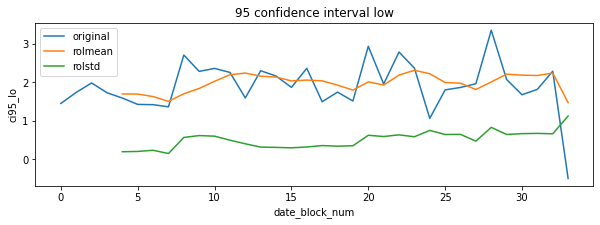

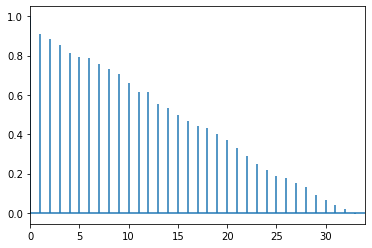

Stationarity test results:
Test statistic                -3.36552
p-value                        0.01219
#Lags used                     4.00000
Number of observations used   29.00000
dtype: float64
Shop_id:  14


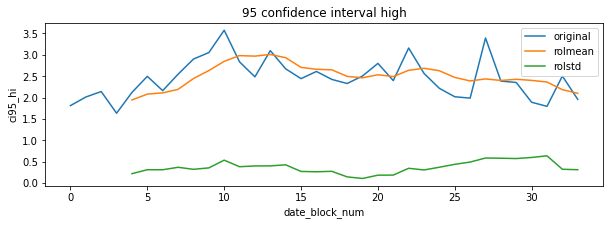

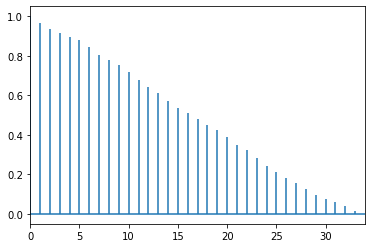

Stationarity test results:
Test statistic                -3.74349
p-value                        0.00354
#Lags used                     0.00000
Number of observations used   33.00000
dtype: float64


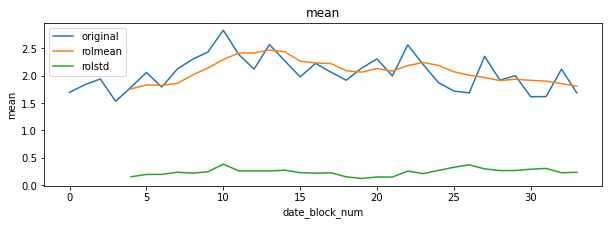

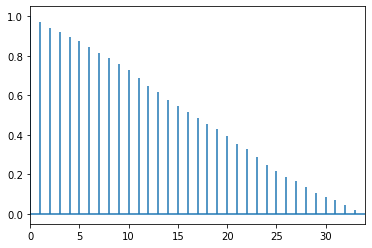

Stationarity test results:
Test statistic                -3.51112
p-value                        0.00771
#Lags used                     0.00000
Number of observations used   33.00000
dtype: float64


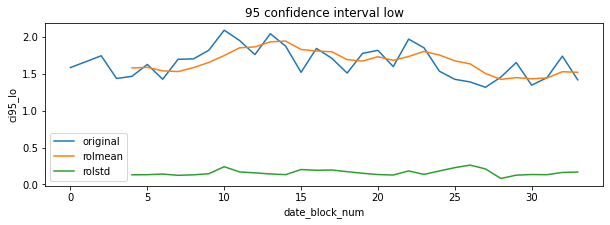

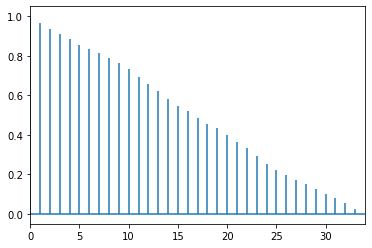

Stationarity test results:
Test statistic                -2.50588
p-value                        0.11405
#Lags used                     3.00000
Number of observations used   30.00000
dtype: float64
Shop_id:  15


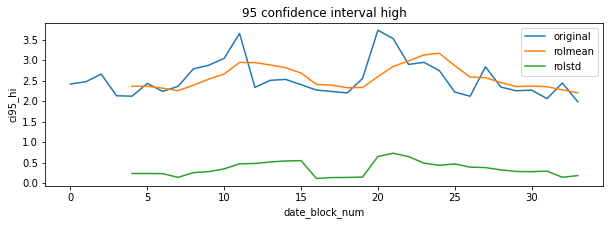

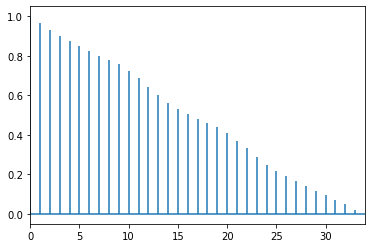

Stationarity test results:
Test statistic                -3.09751
p-value                        0.02674
#Lags used                     0.00000
Number of observations used   33.00000
dtype: float64


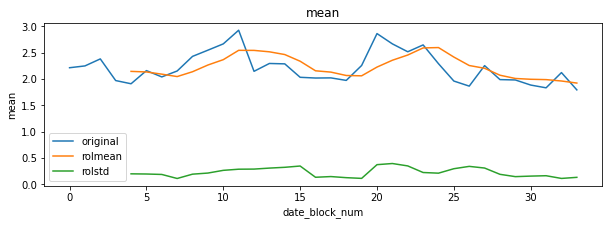

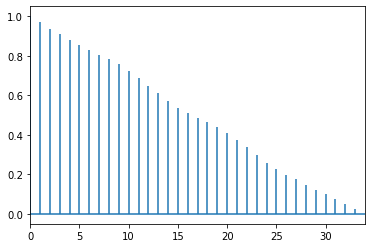

Stationarity test results:
Test statistic                -2.62551
p-value                        0.08784
#Lags used                     0.00000
Number of observations used   33.00000
dtype: float64


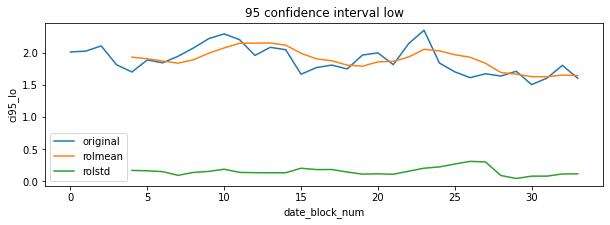

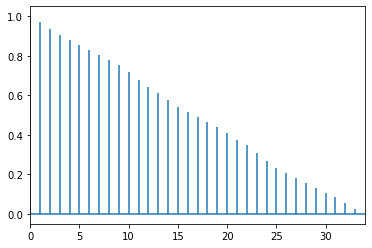

Stationarity test results:
Test statistic                 1.51206
p-value                        0.99757
#Lags used                    10.00000
Number of observations used   23.00000
dtype: float64
Shop_id:  16


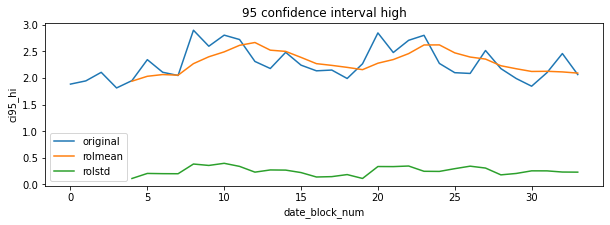

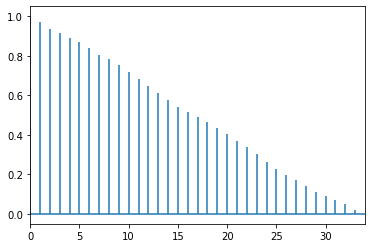

Stationarity test results:
Test statistic                -3.42507
p-value                        0.01013
#Lags used                     0.00000
Number of observations used   33.00000
dtype: float64


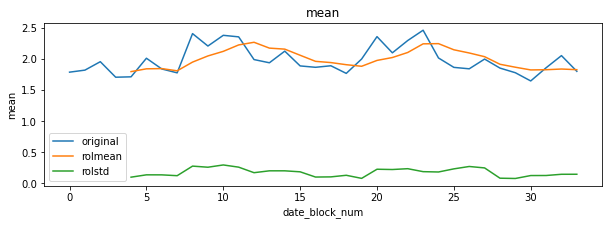

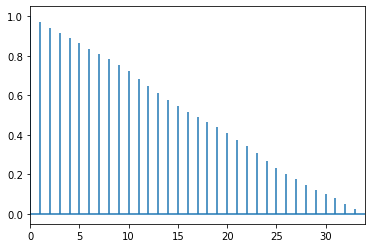

Stationarity test results:
Test statistic                -3.03265
p-value                        0.03196
#Lags used                     3.00000
Number of observations used   30.00000
dtype: float64


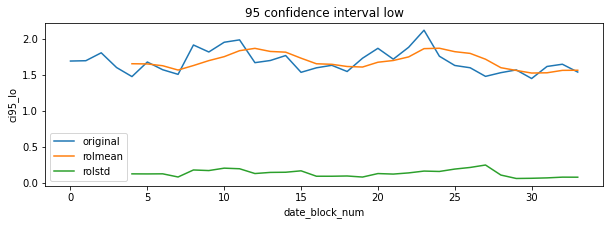

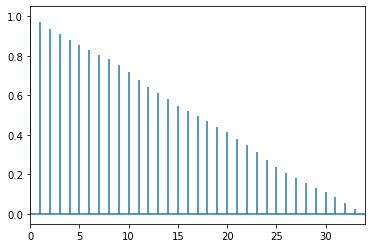

Stationarity test results:
Test statistic                -4.08809
p-value                        0.00101
#Lags used                     3.00000
Number of observations used   30.00000
dtype: float64
Shop_id:  18


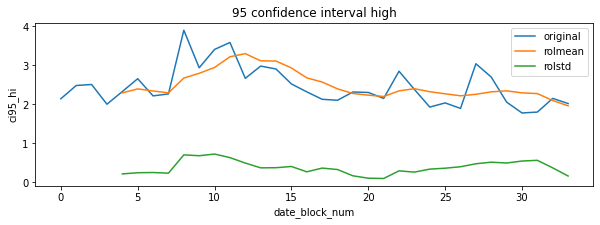

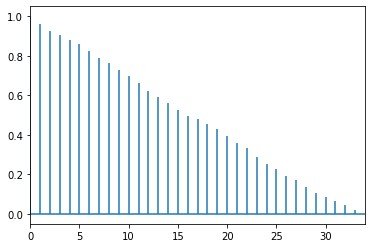

Stationarity test results:
Test statistic                -3.30612
p-value                        0.01461
#Lags used                     0.00000
Number of observations used   33.00000
dtype: float64


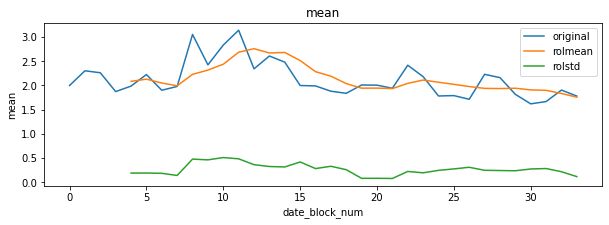

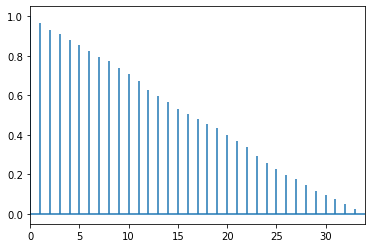

Stationarity test results:
Test statistic                -0.19841
p-value                        0.93871
#Lags used                     8.00000
Number of observations used   25.00000
dtype: float64


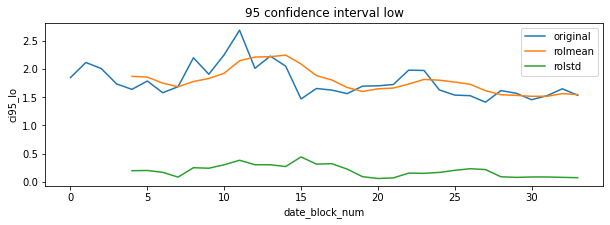

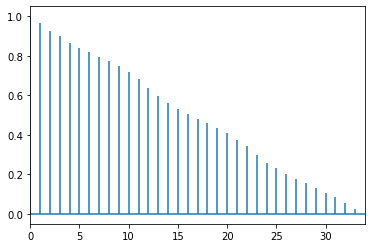

Stationarity test results:
Test statistic                 0.30271
p-value                        0.97747
#Lags used                     8.00000
Number of observations used   25.00000
dtype: float64
Shop_id:  19


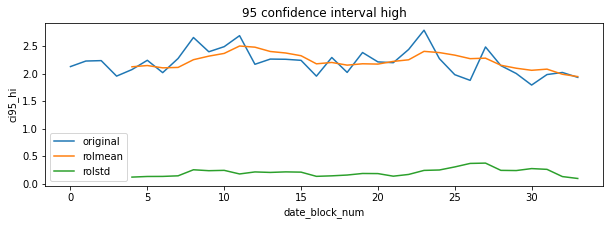

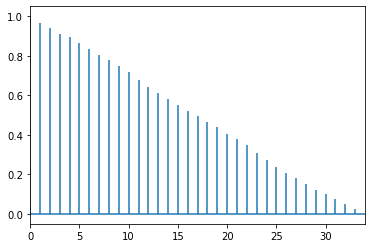

Stationarity test results:
Test statistic                -3.77004
p-value                        0.00323
#Lags used                     0.00000
Number of observations used   33.00000
dtype: float64


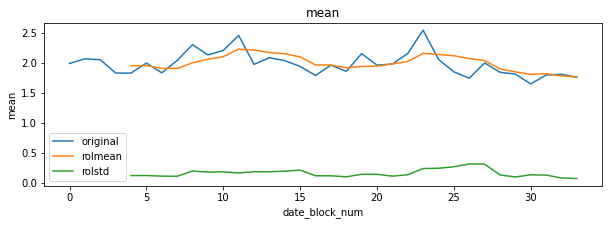

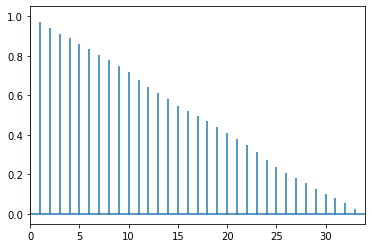

Stationarity test results:
Test statistic                -0.42958
p-value                        0.90504
#Lags used                     7.00000
Number of observations used   26.00000
dtype: float64


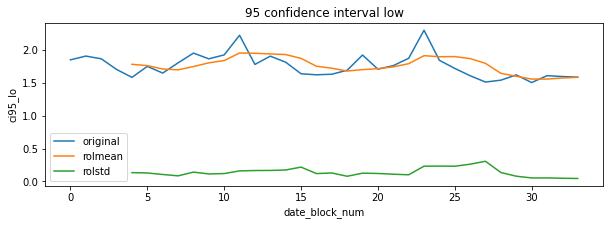

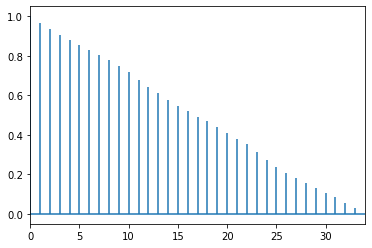

Stationarity test results:
Test statistic                -3.10607
p-value                        0.02611
#Lags used                     0.00000
Number of observations used   33.00000
dtype: float64
Shop_id:  21


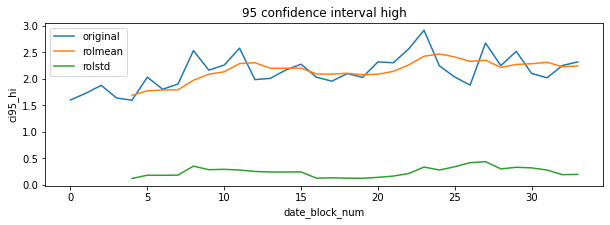

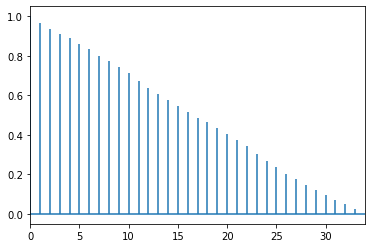

Stationarity test results:
Test statistic                -3.75144
p-value                        0.00345
#Lags used                     0.00000
Number of observations used   33.00000
dtype: float64


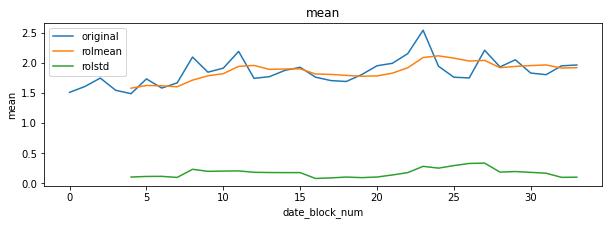

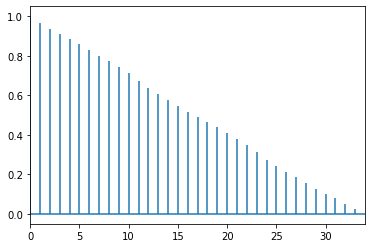

Stationarity test results:
Test statistic                -3.65429
p-value                        0.00480
#Lags used                     0.00000
Number of observations used   33.00000
dtype: float64


KeyboardInterrupt: 

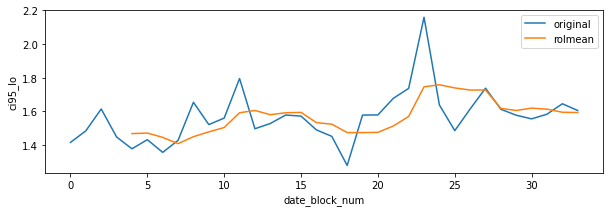

In [76]:
for shop_id in set(test_df.shop_id):
    
    print('=='*100)
    print('Shop_id: ', shop_id)
    
    test_shop_data_stationarity(data, shop_id)

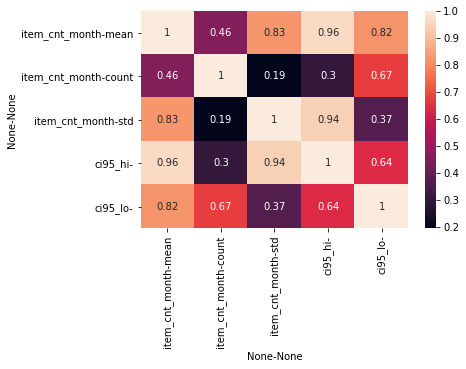

In [34]:
sns.heatmap(stats.corr(), annot=True)
plt.show()